In [1]:
from os.path import join
import json
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import numpy as np

## 1- Load the dataset

In [2]:
root_path = "/srv/data/datasets/visualgenome/"
QA = json.loads(open(join(root_path, 'question_answers.json')).read())
I = json.loads(open(join(root_path, 'image_data.json')).read())

questions = []
answers = []
image_ids = []
for qa in QA:
    for x in qa['qas']:
        questions.append(x['question'])
        answers.append(x['answer'])
        image_ids.append(x['image_id'])
images_paths = {}
for i in I:
    url = '/'.join(i['url'].split('/')[-2:])
    if url.startswith('VG_100K_2/') or url.startswith('VG_100K/'):
        images_paths[i['id']] = url
del QA, I

## 2-a) Keep the spatial questions

In [3]:
words = set("behind close closer closest far farther furthest left right top bottom \
         big biggest bigger small smallest smaller down back above below between near nearest \
         under corner upper high highest higher under beside outside inside front \
         middle around over up besides size away large larger largest thin".split())

IQA = set()
for q,a,i in zip(questions, answers, image_ids):
    qwords = set(q.lower().strip('?').split())
    if len(qwords.intersection(words))>=1:
        IQA.add((i,q,a))
spatial_questions = []
spatial_answers = []
spatial_image_ids = []
for i,q,a in IQA:
    spatial_questions.append(q)
    spatial_answers.append(a)
    spatial_image_ids.append(i)
print("%d questions (%d different)" % (len(spatial_questions), len(set(spatial_questions))))
print("%d answers (%d different)" % (len(spatial_answers), len(set(spatial_answers))))
print("%d images (%d different)" % (len(spatial_image_ids), len(set(spatial_image_ids))))

151693 questions (97098 different)
151693 answers (40517 different)
151693 images (54823 different)


In [27]:
images_set = list(set(spatial_image_ids))
np.random.shuffle(images_set)
n_train = int(len(images_set)*0.7)
train_images = set(images_set[:n_train])
test_images = set(images_set[n_train+1:])

train_imgfile = open('datasets/visualgenome/train/img_ids.txt','w')
test_imgfile = open('datasets/visualgenome/test/img_ids.txt','w')
train_questionfile = open('datasets/visualgenome/train/questions.txt','w')
test_questionfile = open('datasets/visualgenome/test/questions.txt','w')
train_answerfile = open('datasets/visualgenome/train/answers.txt','w')
test_answerfile = open('datasets/visualgenome/test/answers.txt','w')
for i,q,a in IQA:
    if i in train_images:
        questions_file = train_questionfile
        answers_file = train_answerfile
        imgs_file = train_imgfile
    if i in test_images:
        questions_file = test_questionfile
        answers_file = test_answerfile
        imgs_file = test_imgfile
    questions_file.write(q + '\n')
    answers_file.write(a + '\n')
    imgs_file.write(str(i) + '\n')

train_imgfile.close()
test_imgfile.close()
train_questionfile.close()
test_questionfile.close()
train_answerfile.close()
test_answerfile.close()

In [30]:
features_file = open('datasets/visualgenome/images.feat')
train_featfile = open('datasets/visualgenome/train/images.feat','w')
test_featfile = open('datasets/visualgenome/test/images.feat','w')
for l in features_file:
    idx = int(l.strip().split(';')[0])
    if idx in train_images:
        train_featfile.write(l)
    if idx in test_images:
        test_featfile.write(l)
        

## 3- Some stats about the answers

### 3-a) Answers

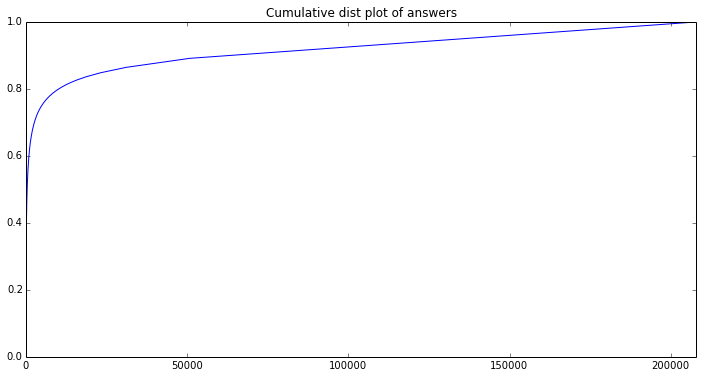

White. - 2.98425%
One. - 2.63658%
Daytime. - 1.85114%
Black. - 1.70543%
Green. - 1.64794%
Blue. - 1.58726%
Two. - 1.48617%
Brown. - 1.28200%
Red. - 1.10681%
1. - 0.84867%

Length = 1445322
Number of tokens = 207675


In [5]:
ct = Counter(answers)
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of answers")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))
    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 3-b) Spatial answers

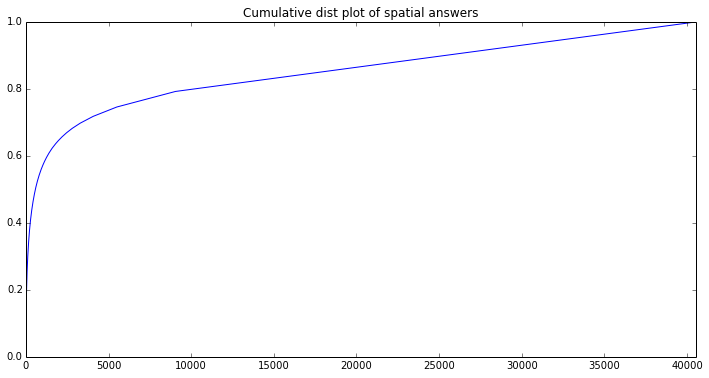

Trees. - 2.16160%
White. - 1.59928%
Red. - 1.19518%
Blue. - 1.12332%
Black. - 1.03762%
Green. - 0.84711%
Yellow. - 0.80162%
Grass. - 0.76998%
Water. - 0.72844%
Brown. - 0.58012%

Length = 151693
Number of tokens = 40517


In [59]:
ct = Counter(spatial_answers)
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of spatial answers")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))
        
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 3-c) Vocab in answers

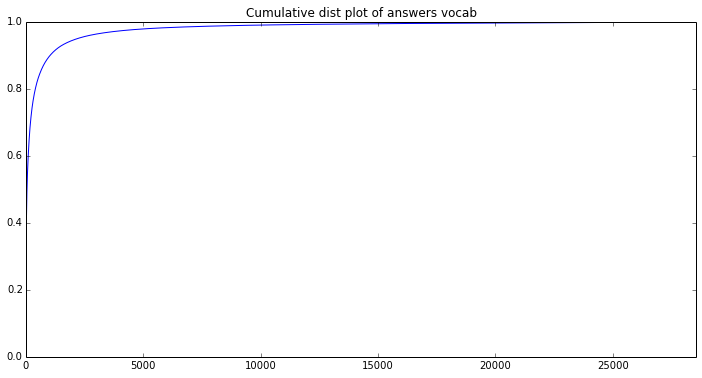

the - 8.78814%
a - 6.95917%
on - 3.54306%
white - 2.63045%
in - 2.23040%
and - 1.72703%
one - 1.69787%
black - 1.54831%
blue - 1.33339%
green - 1.20326%

Length = 2774125
Number of tokens = 28523


In [77]:
ct = Counter([w for a in answers for w in a.lower().strip('.').split()])
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of answers vocab")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 3-d) Vocab in spatial answers

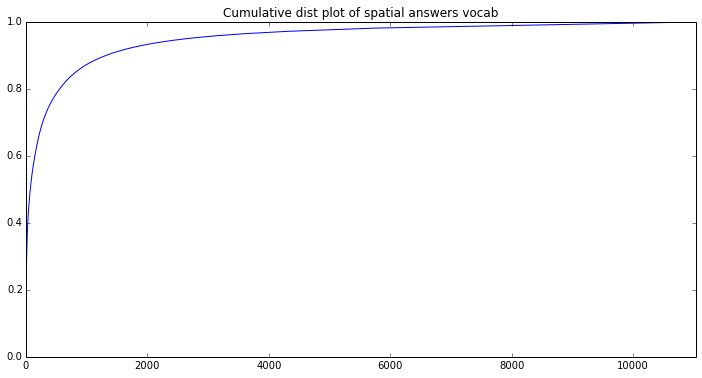

a - 11.54808%
the - 5.04216%
white - 2.02108%
trees - 1.47757%
and - 1.45305%
black - 1.24656%
of - 1.21444%
blue - 1.20615%
red - 1.15850%
on - 1.09635%

Length = 289598
Number of tokens = 11022


In [75]:
ct = Counter([w for a in spatial_answers for w in a.lower().strip('.').split()])
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of spatial answers vocab")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

## 4- Some stats about the questions

### 4-a) Questions

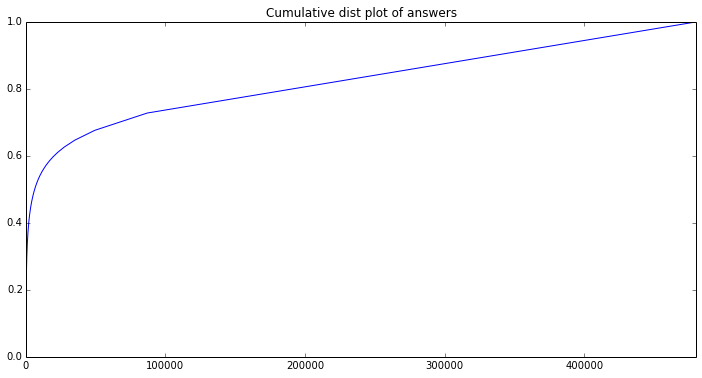

When was the picture taken? - 0.64435%
When was the photo taken? - 0.63467%
What is in the background? - 0.57503%
What color is the sky? - 0.56970%
Where was the photo taken? - 0.48349%
What color is the grass? - 0.41776%
What is the man doing? - 0.41472%
When was this picture taken? - 0.41188%
Where was the picture taken? - 0.40392%
When was this photo taken? - 0.37168%

Length = 1445322
Number of tokens = 479904


In [62]:
ct = Counter(questions)
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of answers")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 4-b) Spatial questions

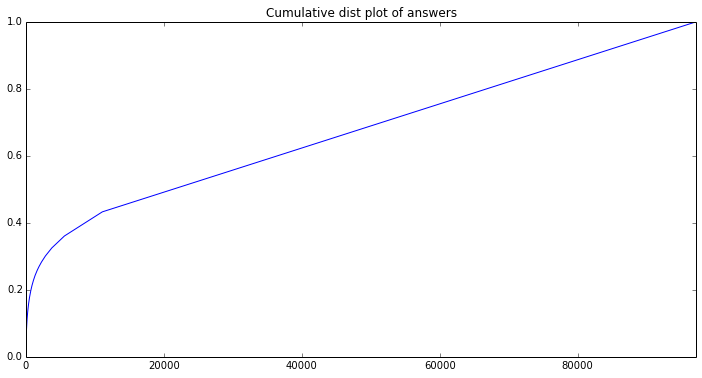

What is behind the man? - 0.59792%
What is behind the fence? - 0.29731%
What is behind the woman? - 0.25314%
What is around the man's neck? - 0.22414%
What is behind the bench? - 0.17667%
What is above the train? - 0.16810%
What is behind the giraffe? - 0.16613%
What is behind the people? - 0.16085%
What is behind the trees? - 0.15558%
What is around the woman's neck? - 0.15360%

Length = 151693
Number of tokens = 97098


In [63]:
ct = Counter(spatial_questions)
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of answers")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 4-c) Vocab in questions

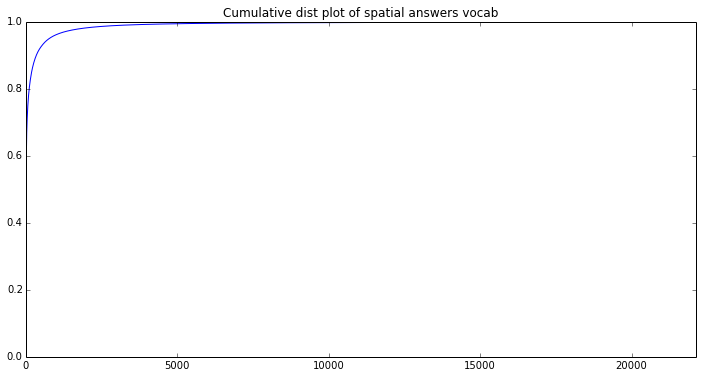

the - 15.11442%
is - 11.84593%
what - 10.45280%
are - 3.38744%
where - 2.94608%
on - 2.50278%
color - 2.49890%
of - 2.43665%
in - 2.07482%
how - 1.89229%

Length = 8310829
Number of tokens = 22114


In [64]:
ct = Counter([w for a in questions for w in a.lower().strip('?').split()])
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of spatial answers vocab")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

### 4-d) Vocab in spatial questions

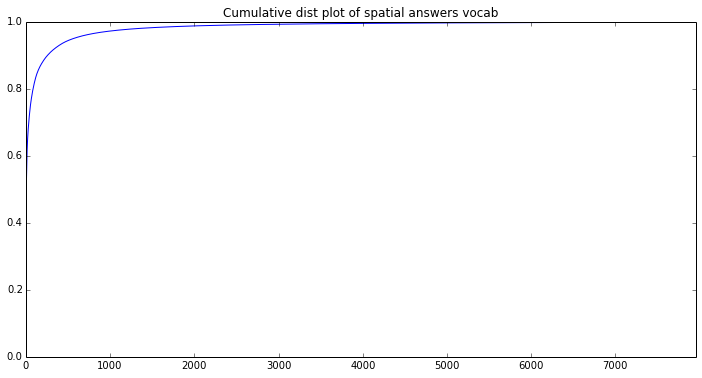

the - 17.70993%
is - 11.50667%
what - 11.50506%
of - 4.16962%
on - 3.47479%
in - 2.27537%
behind - 1.97643%
left - 1.36361%
right - 1.29557%
front - 1.29127%

Length = 1116961
Number of tokens = 7953


In [65]:
ct = Counter([w for a in spatial_questions for w in a.lower().strip('?').split()])
counts = list(ct.values())
counts = sorted(counts, reverse=True)
S = sum(counts)
freqs = np.array(counts) / S
cum = np.cumsum(freqs)
plt.figure(figsize=(12,6))
plt.ylim([0,1])
plt.xlim([0,len(ct)])
plt.plot(cum)
plt.title("Cumulative dist plot of spatial answers vocab")
plt.show()
for w,c in ct.most_common(10):
    print("%s - %1.5f%%" % (w,100*c/S))    
print("\nLength = %d" % S)
print("Number of tokens = %d" % len(ct))

In [ ]:
import colorsys
import webcolors
from webcolors import rgb_to_hex, hex_to_rgb

colordict = webcolors.CSS21_HEX_TO_NAMES
#modifying the orange
colordict.pop("#ffa500")
colordict["#ff5200"] = "orange"
hsv_colordict = {}
for k,v in colordict.items():
    r,g,b = webcolors.hex_to_rgb(k)
    r /= 255.
    g /= 255.
    b /= 255.
    hsv = colorsys.rgb_to_hsv(r,g,b)
    hsv_colordict[v] = hsv

In [165]:
for k in the_dict:
    print(k, the_dict[k])

#e6e6fa lavender
#90ee90 lightgreen
#f8f8ff ghostwhite
#ffc0cb pink
#da70d6 orchid
#778899 lightslategrey
#ffffff white
#708090 slategrey
#00ff00 lime
#f5f5dc beige
#a0522d sienna
#ffdab9 peachpuff
#a52a2a brown
#ffebcd blanchedalmond
#e0ffff lightcyan
#556b2f darkolivegreen
#ffffe0 lightyellow
#d2b48c tan
#87ceeb skyblue
#dda0dd plum
#ff0000 red
#d8bfd8 thistle
#32cd32 limegreen
#f0e68c khaki
#800080 purple
#4b0082 indigo
#808000 olive
#adff2f greenyellow
#ff1493 deeppink
#8a2be2 blueviolet
#4169e1 royalblue
#ee82ee violet
#228b22 forestgreen
#ffb6c1 lightpink
#faf0e6 linen
#9acd32 yellowgreen
#00ff7f springgreen
#b0c4de lightsteelblue
#7fffd4 aquamarine
#008b8b darkcyan
#98fb98 palegreen
#0000cd mediumblue
#ff8c00 darkorange
#f08080 lightcoral
#40e0d0 turquoise
#ffefd5 papayawhip
#fdf5e6 oldlace
#ffa07a lightsalmon
#00ffff cyan
#48d1cc mediumturquoise
#5f9ea0 cadetblue
#87cefa lightskyblue
#cd5c5c indianred
#00008b darkblue
#3cb371 mediumseagreen
#db7093 palevioletred
#800000 maroon


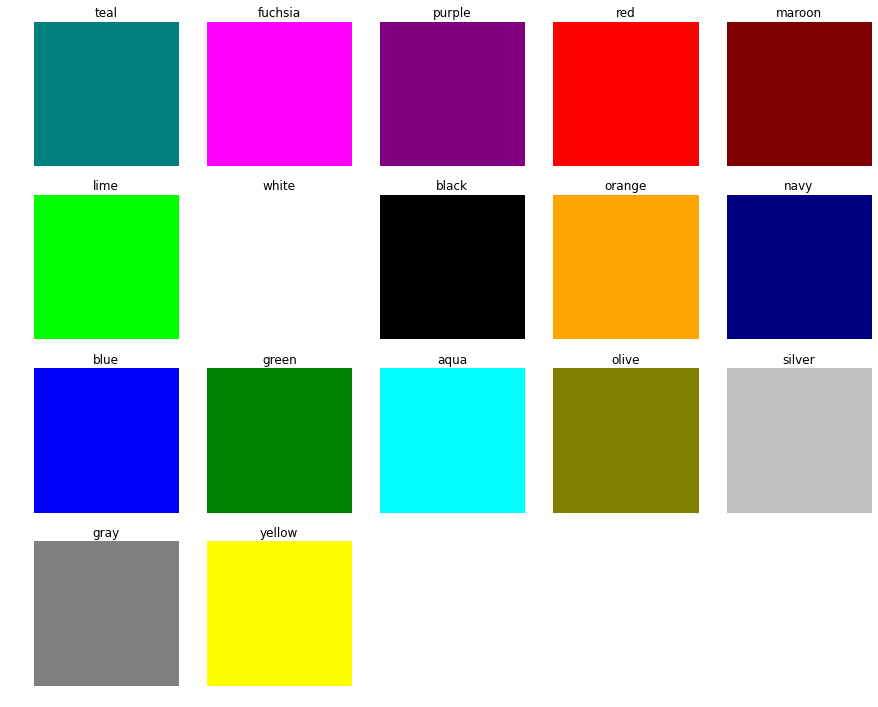

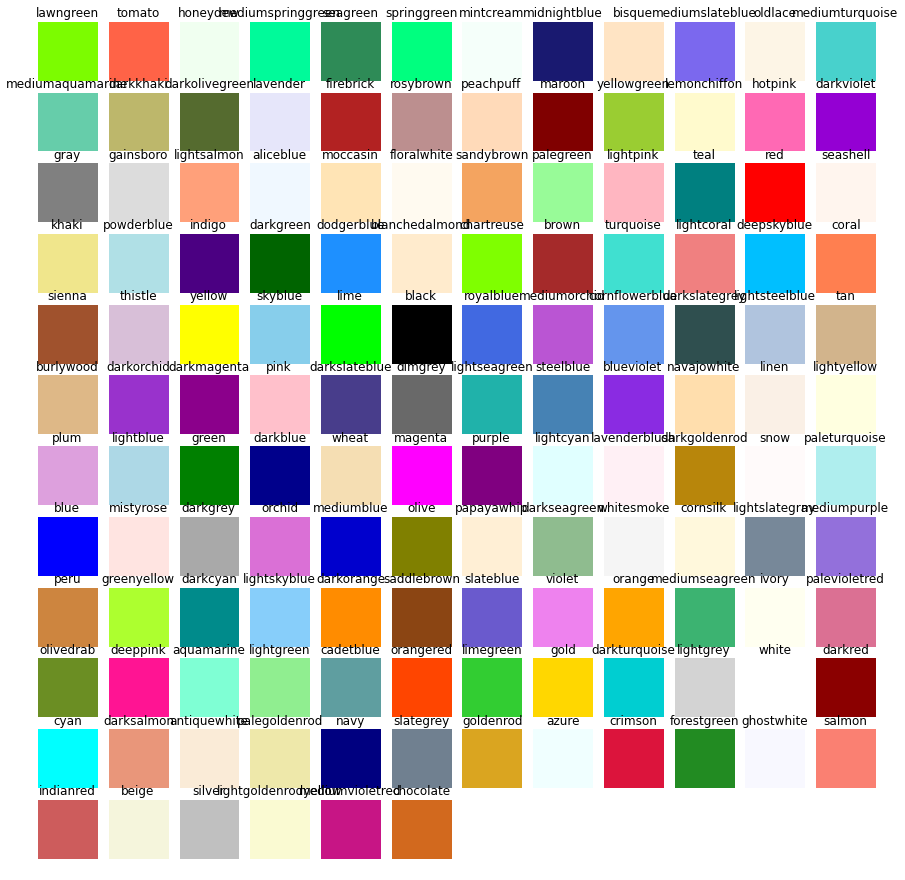

In [11]:
import webcolors
# the_dict = webcolors.CSS3_HEX_TO_NAMES
colordict = json.loads(open('/home/hbenyounes/nshots/colors.json').read())
# the_dict = colordict
for the_dict in [webcolors.CSS21_HEX_TO_NAMES, webcolors.CSS3_HEX_TO_NAMES]:
    N = len(the_dict)
    n_grid = int(np.sqrt(N)) +1
    plt.figure(figsize=(15,15))
    for i,hexa in enumerate(the_dict):
        plt.subplot(n_grid,n_grid,i+1)
        rgb = hex_to_rgb(hexa)
        plt.imshow(256-np.array(rgb)[None,None,:])
        plt.axis('off')
        plt.title(the_dict[hexa])
    plt.show()

In [1]:
import colorsys
import webcolors
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from webcolors import rgb_to_hex, hex_to_rgb
# colordict = json.loads(open('/home/hbenyounes/nshots/colors.json').read())
colordict = webcolors.CSS3_HEX_TO_NAMES
hsv_colordict = {}
for k,v in colordict.items():
    r,g,b = webcolors.hex_to_rgb(k)
    r /= 255.
    g /= 255.
    b /= 255.
    hsv = colorsys.rgb_to_hsv(r,g,b)
    hsv_colordict[v] = hsv
len(hsv_colordict)

138

saddlebrown


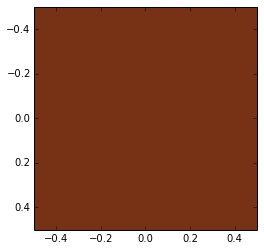

In [2]:
def closest_colour_hsv(rgb):
    rgb = (rgb[0]/255., rgb[1]/255., rgb[2]/255.)
    min_colors = {}
    h,s,v = colorsys.rgb_to_hsv(rgb[0],rgb[1],rgb[2])
    for name, hsv in hsv_colordict.items():
        dist = (h-hsv[0])**2
        dist += (s - hsv[1])**2
        dist += (v - hsv[2])**2
        min_colors[name] = dist
    return min_colors

def closest_colour_rgb(rgb):
    rgb = [rgb[0]/256., rgb[1]/256., rgb[2]/256.]
    min_colors = {}
    for hexa,name in colordict.items():
        rgb_l = [x/256. for x in webcolors.hex_to_rgb(hexa)]
        dist = sum( [(x-y)**2 for x,y in zip(rgb,rgb_l)] )
        min_colors[name] = dist
    return min_colors

# hexa = "#FA6621"
# hexa = "#EB3E24"
hexa = "#773115"
rgb = hex_to_rgb(hexa)
plt.figure()
plt.imshow(256-np.array(rgb)[None,None,:])
colors = closest_colour_rgb(rgb)
print(min(colors, key=colors.get))

In [ ]:
hex_file = open('/home/hbenyounes/vivatech/vivatech_hex_all.csv','r')
with open('/home/hbenyounes/vivatech/vivatech_colors138_all.csv','w') as f:
    for l in hex_file:
        l = l.rstrip().rstrip(';').split(';')
        l_out = []
        for x in l:
            if x.startswith('#'):
                rgb = hex_to_rgb(x)
                color = closest_colour_rgb(rgb)
                x = min(color, key=color.get)
            l_out.append(x)
        l_out = ';'.join(l_out) + ';\n'
        f.write(l_out)